In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import pickle
import json
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df_demanda = pd.read_csv('..\TESTEO UPDATE\df_demanda.csv')

In [3]:
df_exchanges = pd.read_csv('..\TESTEO UPDATE\df_exchanges.csv')

In [4]:
df_generation = pd.read_csv('..\TESTEO UPDATE\df_generation.csv')

In [5]:
def preprocess_data(df_demanda, df_exchanges, df_generation):
    # Eliminar columnas innecesarias
    df_demanda = df_demanda.drop(columns=["fecha_extraccion"])
    df_exchanges = df_exchanges.drop(columns=["fecha_extraccion"])
    df_generation = df_generation.drop(columns=["fecha_extraccion"])


    # Filtrar y limpiar df_generation
    df_generation_filtered = df_generation[(df_generation['energia'] == 'Generación total') | (df_generation['tipo_tecnología'] == 'Generación total')]
    df_generation_filtered = df_generation_filtered.drop(columns=['energia', 'tipo_tecnología'])
    df_generation_filtered = df_generation_filtered.reset_index(drop=True)

    # Filtrar df_exchanges
    df_exchanges_filtered = df_exchanges[(df_exchanges['tipo_transaccion'] == 'saldo')]
    df_exchanges_agg = df_exchanges_filtered.groupby("fecha", as_index=False)["valor_MW"].sum()

    # Merge de los DataFrames
    df_merge_test = df_demanda.merge(df_exchanges_agg, on="fecha", how="left")
    df_merge_test = df_merge_test.rename(columns={"valor_MW": "saldo_intercambios"})
    df_merge_test = df_merge_test.merge(df_generation_filtered, on="fecha", how="left")
    
    # Interpolación de valores NaN'S en 'saldo_intercambios'
    df_merge_test['saldo_intercambios'] = df_merge_test['saldo_intercambios'].interpolate(method='linear')

    # Crear nuevas columnas basadas en la fecha
    df_merge_test['fecha'] = pd.to_datetime(df_merge_test['fecha'], format='%Y-%m-%d')
    df_merge_test['año'] = df_merge_test['fecha'].dt.year
    df_merge_test['mes'] = df_merge_test['fecha'].dt.month
    df_merge_test['dia'] = df_merge_test['fecha'].dt.day
    df_merge_test['dia_semana'] = df_merge_test['fecha'].dt.weekday
    df_merge_test['es_fin_de_semana'] = df_merge_test['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)
    df_merge_test = df_merge_test.drop(columns=["fecha"])

    return df_merge_test

In [6]:
df=preprocess_data(df_demanda, df_exchanges, df_generation)

In [7]:
df

,valor_demanda_MW,saldo_intercambios,valor_generacion_MW,año,mes,dia,dia_semana,es_fin_de_semana
0,605986.216,-9451.187,627410.852,2011,1,1,5,1
1,641856.087,-25873.160,685838.021,2011,1,2,6,1
2,801297.365,-31853.835,842917.239,2011,1,3,0,0
3,833253.263,-32769.274,871499.828,2011,1,4,1,0
4,803475.573,-23665.904,838808.749,2011,1,5,2,0
...,...,...,...,...,...,...,...,...
5073,711494.828,17064.572,841477.628,2024,11,21,3,0
5074,704373.070,17064.572,761081.870,2024,11,22,4,0
5075,623226.759,17064.572,629371.559,2024,11,23,5,1
5076,583994.038,17064.572,664105.738,2024,11,24,6,1


In [8]:
def escalador(df, T=7, target_column= 'valor_demanda_MW', scaler_filename="scaler.pkl"):

    columnas_a_escalar = df.drop(columns=[target_column]).columns
    valores = df[columnas_a_escalar].values
    objetivo = df[target_column].values

    # Seleccionar las columnas a escalar, excluyendo la columna objetivo
    valores = valores
    objetivo = objetivo
    
    # Crear y ajustar el escalador
    scaler = StandardScaler()
    valores_escalados = scaler.fit_transform(valores)
    objetivo_escalado = scaler.fit_transform(objetivo.reshape(-1,1))
    
    # Dar forma a los valores escalados
    #valores_escalados = valores_escalados.reshape((valores_escalados.shape[0],valores_escalados.shape[1], 1))
    
    # Guardar el escalador en un archivo pickle
    with open(scaler_filename, "wb") as f:
        pickle.dump(scaler, f)

    # Crear listas para las secuencias de entrada y salida
    X = []
    y = []
    
    # Generar ventanas deslizantes
    for t in range(len(df) - T):
        # Toma valores de X de t en t con stride de 1
        x = valores_escalados[t : t + T]
        X.append(x)
        
        # Toma los valores de t en t
        y_ = objetivo_escalado[t + T]
        y.append(y_)
    
    # Convertir listas a arrays de numpy
    X = np.array(X)  # Dimensión: (samples, timesteps, features)
    y = np.array(y)  # Dimensión: (samples, 1)
    
    return X, y

In [9]:
valores_escalados, objetivo_escalado=escalador(df)

In [10]:
valores_escalados.shape

(5071, 7, 7)

In [11]:
objetivo_escalado.shape

(5071, 1)

In [12]:
def train_test_split_data(valores_escalados, objetivo_escalado, train_ratio=0.8):
    # Calcular el tamaño del conjunto de entrenamiento
    train_size = int(len(valores_escalados) * train_ratio)
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = valores_escalados[:train_size], valores_escalados[train_size:]
    y_train, y_test = objetivo_escalado[:train_size], objetivo_escalado[train_size:]
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test=train_test_split_data(valores_escalados, objetivo_escalado)

In [14]:
def modelo_neuronal_RNN (X_train, y_train, X_test, y_test, T=7, scaler_filename="scaler.pkl", model_filename="rnn_model.pkl"):
    
    # Cargar el escalador preentrenado desde el archivo pickle
    with open(scaler_filename, "rb") as f:
        scaler = pickle.load(f)
    
    # Definición del modelo
    model = Sequential()
    model.add(Input(shape=(T, 7)))
    model.add(SimpleRNN(units=256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(units=32, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(units=16, kernel_regularizer=l2(0.01)))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mse")

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Entrenamiento del modelo
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,callbacks=[early_stopping])

    # Guardar los valores en un archivo JSON
    with open("history_rnn.json", "w") as f:
        json.dump(history.history, f)

    
    # Realizar predicciones
    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)
    expected = scaler.inverse_transform(y_test)

    # Guardar el modelo en un archivo pickle
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.plot(history.history["loss"], label = "loss")
    plt.legend()
    plt.show()
    
    # Mostrar predicciones y graficar resultados
    for i in range(len(y_test)):
        print(f"Real: {expected[i]} | Predicción: {predictions[i]}")

    plt.plot(expected, color="blue", alpha=0.7, label="objetivo")
    plt.plot(predictions, color="green", alpha=0.7, label="prediccion")
    plt.legend()
    plt.show()

    return model, history

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.7998 - val_loss: 2.2971
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1617 - val_loss: 1.5837
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3727 - val_loss: 1.0517
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9255 - val_loss: 0.7494
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6665 - val_loss: 0.5429
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5382 - val_loss: 0.4610
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4356 - val_loss: 0.3857
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3500 - val_loss: 0.3176
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3125 - val_loss: 0.3457
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2843 - val_loss: 0.2640
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2593 - val_loss: 0.2531
Epoch 12/200
127/127 ━━━━━━━━━━━━━━━━━━━━

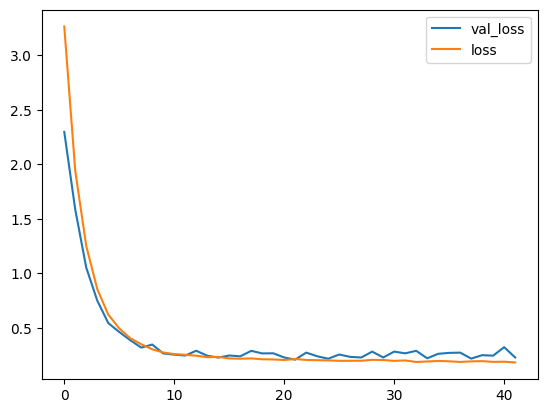

Real: [759124.039] | Predicción: [754993.2]
Real: [758265.98] | Predicción: [737029.44]
Real: [744050.02] | Predicción: [762223.2]
Real: [735427.048] | Predicción: [741275.8]
Real: [677992.558] | Predicción: [668279.5]
Real: [628491.111] | Predicción: [623912.94]
Real: [726597.17] | Predicción: [734171.1]
Real: [734120.281] | Predicción: [726962.75]
Real: [732237.567] | Predicción: [717058.5]
Real: [736907.737] | Predicción: [702810.7]
Real: [742820.885] | Predicción: [695016.06]
Real: [670693.047] | Predicción: [654525.75]
Real: [618013.898] | Predicción: [606121.]
Real: [697748.424] | Predicción: [702225.5]
Real: [722629.686] | Predicción: [714280.3]
Real: [735689.298] | Predicción: [708764.5]
Real: [742779.369] | Predicción: [700867.25]
Real: [743386.909] | Predicción: [729310.4]
Real: [660787.324] | Predicción: [686944.]
Real: [620251.472] | Predicción: [611727.44]
Real: [732493.133] | Predicción: [716548.5]
Real: [735113.962] | Predicción: [749941.2]
Real: [726757.341] | Predicció

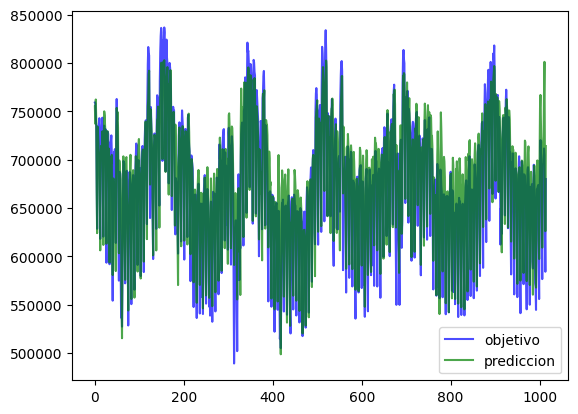

(<Sequential name=sequential, built=True>,
 <keras.src.callbacks.history.History at 0x1a9b8b2d290>)

In [15]:
modelo_neuronal_RNN(X_train, y_train, X_test, y_test)

In [16]:
X_test.shape

(1015, 7, 7)

In [17]:
def predict_7_days(scaler_filename="scaler.pkl", model_filename="rnn_model.pkl",last_sequence=X_test):

    with open(scaler_filename, "rb") as f:
        scaler = pickle.load(f)
    
    with open(model_filename, "rb") as f:
        model = pickle.load(f)
    
    #predictions_scaled = []
    #input_sequence = last_sequence.copy()

    #for _ in range(7):  # Predecir 7 días
        # Redimensionar la secuencia para cumplir con el formato del modelo
        #input_sequence_reshaped = input_sequence.reshape(1, input_sequence.shape[0], input_sequence.shape[1])

        # Realizar la predicción
        #prediction_scaled = model.predict(input_sequence_reshaped)[0, 0]  # Extraer el valor escalar
        #predictions_scaled.append(prediction_scaled)

        # Actualizar la secuencia de entrada
        #input_sequence = np.append(input_sequence_reshaped[:,1,:], [[prediction_scaled]], axis=0)
    #predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))
 
    #return predictions
    if last_sequence.ndim == 3:
        last_sequence = last_sequence[0]  

    if last_sequence is None or last_sequence.ndim != 2:
        raise ValueError("`last_sequence` debe ser un array 2D con forma (T, n_features).")
    
    predictions_scaled = []
    input_sequence = last_sequence.reshape(7,7)

    for _ in range(7):  # Predecir 7 días
        # Redimensionar la secuencia para cumplir con el formato del modelo
        input_sequence_reshaped = input_sequence.reshape(1, input_sequence.shape[0], input_sequence.shape[1])

        # Realizar la predicción
        prediction_scaled = model.predict(input_sequence_reshaped)[0, 0]  # Extraer el valor escalar
        predictions_scaled.append(prediction_scaled)

        # Actualizar la secuencia de entrada
        # Desplazar los timesteps anteriores y añadir la nueva predicción como una característica adicional
        new_timestep = np.zeros(input_sequence.shape[1])
        new_timestep[0] = prediction_scaled  # Suponiendo que la predicción corresponde a la primera característica
        input_sequence = np.vstack((input_sequence[1:], new_timestep))
    
    # Invertir la escala de las predicciones
    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))
    
    return predictions
    

In [18]:
predictions_7 = predict_7_days()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [19]:
predictions_7

array([[754993.2 ],
       [722843.9 ],
       [724863.6 ],
       [718933.7 ],
       [670721.5 ],
       [645540.06],
       [691124.44]], dtype=float32)

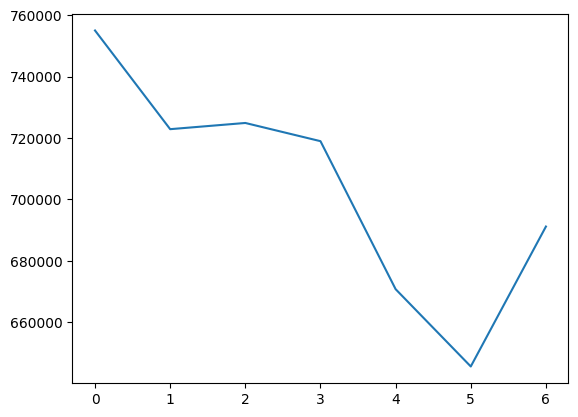

In [20]:
plt.plot(predictions_7)

In [21]:
def modelo_neuronal_lstm (X_train, y_train, X_test, y_test, T=7,scaler_filename="scaler.pkl", model_filename="lstm_model.pkl"):
    # Cargar el escalador preentrenado desde el archivo pickle
    with open(scaler_filename, "rb") as f:
        scaler = pickle.load(f)
    
    # Definición del modelo LSTM
    model_lstm = Sequential()
    model_lstm.add(Input(shape=(T, 7)))
    model_lstm.add(LSTM(units=256, activation='tanh', kernel_regularizer=l2(0.01)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(units=128, activation='tanh', kernel_regularizer=l2(0.01)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(units=64, activation='tanh', kernel_regularizer=l2(0.01)))
    model_lstm.add(Dense(units=32, kernel_regularizer=l2(0.01)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(units=16, kernel_regularizer=l2(0.01)))
    model_lstm.add(Dense(units=1))
    optimizer = Adam(learning_rate=0.001)
    model_lstm.compile(optimizer=optimizer, loss="mse")


    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Entrenamiento del modelo
    history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,callbacks=[early_stopping])
    
    with open("history_lstm.json", "w") as f:
        json.dump(history_lstm.history, f)

    # Realizar predicciones
    predictions_scaled = model_lstm.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)
    expected = scaler.inverse_transform(y_test)

    # Guardar el modelo en un archivo pickle
    with open(model_filename, "wb") as f:
        pickle.dump(model_lstm, f)

    plt.plot(history_lstm.history["val_loss"], label = "val_loss")
    plt.plot(history_lstm.history["loss"], label = "loss")
    plt.legend()
    plt.show()
    
    # Mostrar predicciones y graficar resultados
    for i in range(len(y_test)):
        print(f"Real: {expected[i]} | Predicción: {predictions[i]}")

    plt.plot(expected, color="blue", alpha=0.7, label="objetivo")
    plt.plot(predictions, color="green", alpha=0.7, label="prediccion")
    plt.legend()
    plt.show()

    return model_lstm, history_lstm

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 3.5493 - val_loss: 2.0627
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7794 - val_loss: 1.0690
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9887 - val_loss: 0.6588
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.6010 - val_loss: 0.4893
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4465 - val_loss: 0.3626
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3502 - val_loss: 0.3015
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3231 - val_loss: 0.3889
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2974 - val_loss: 0.2529
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3037 - val_loss: 0.2682
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2748 - val_loss: 0.2476
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2626 - val_loss: 0.3474
Epoch 12/200
127/127 ━━━━━━━━━

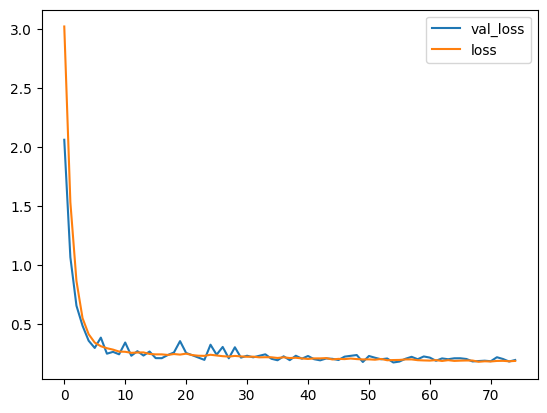

Real: [759124.039] | Predicción: [762286.1]
Real: [758265.98] | Predicción: [753520.56]
Real: [744050.02] | Predicción: [765538.25]
Real: [735427.048] | Predicción: [750600.7]
Real: [677992.558] | Predicción: [677087.7]
Real: [628491.111] | Predicción: [638300.94]
Real: [726597.17] | Predicción: [732627.94]
Real: [734120.281] | Predicción: [740836.5]
Real: [732237.567] | Predicción: [732477.8]
Real: [736907.737] | Predicción: [721232.1]
Real: [742820.885] | Predicción: [720404.7]
Real: [670693.047] | Predicción: [670893.6]
Real: [618013.898] | Predicción: [604781.8]
Real: [697748.424] | Predicción: [698551.8]
Real: [722629.686] | Predicción: [711725.06]
Real: [735689.298] | Predicción: [716106.5]
Real: [742779.369] | Predicción: [713984.25]
Real: [743386.909] | Predicción: [720608.56]
Real: [660787.324] | Predicción: [667518.4]
Real: [620251.472] | Predicción: [604457.1]
Real: [732493.133] | Predicción: [717443.9]
Real: [735113.962] | Predicción: [741746.44]
Real: [726757.341] | Predic

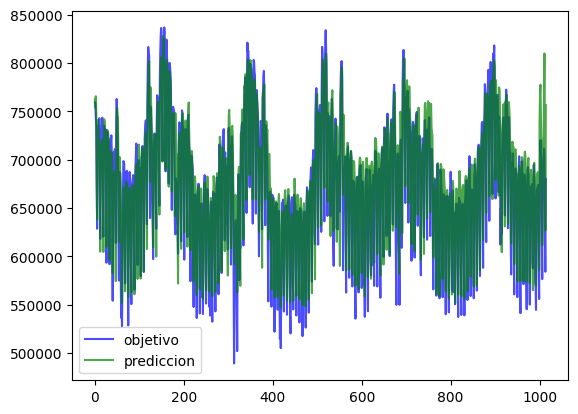

(<Sequential name=sequential_1, built=True>,
 <keras.src.callbacks.history.History at 0x1a9c11db850>)

In [22]:
modelo_neuronal_lstm(X_train, y_train, X_test, y_test)

In [23]:
predictions_7_lstm = predict_7_days(model_filename="lstm_model.pkl")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [24]:
predictions_7_lstm

array([[762286.1 ],
       [742150.1 ],
       [731999.75],
       [727302.2 ],
       [672533.2 ],
       [652404.75],
       [712968.5 ]], dtype=float32)

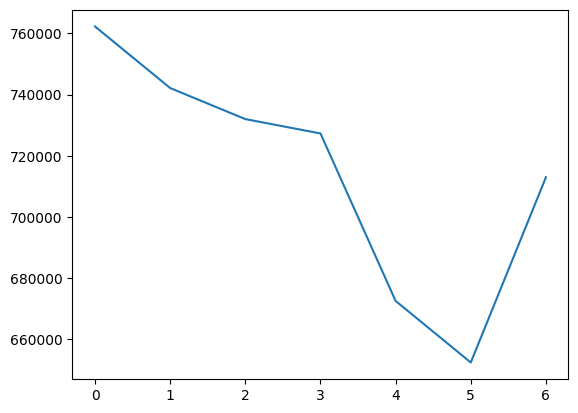

In [25]:
plt.plot(predictions_7_lstm)

In [26]:
from keras.layers import GRU, Dense

In [27]:
def modelo_neuronal_GRU (X_train, y_train, X_test, y_test, T=7,scaler_filename="scaler.pkl", model_filename="gru_model.pkl"):
    # Cargar el escalador preentrenado desde el archivo pickle
    with open(scaler_filename, "rb") as f:
        scaler = pickle.load(f)
    
    # Definición del modelo LSTM
    model_gru = Sequential()
    model_gru.add(GRU(units=128, activation="tanh", use_cudnn="auto", input_shape=(T, 7), kernel_regularizer=l2(0.02)))
    model_gru.add(Dropout(0.5))
    model_gru.add(Dense(units=64, activation="tanh", kernel_regularizer=l2(0.02)))
    model_gru.add(Dropout(0.5))
    model_gru.add(Dense(units=32, activation="tanh", kernel_regularizer=l2(0.02)))
    model_gru.add(Dropout(0.5))
    model_gru.add(Dense(units=16, kernel_regularizer=l2(0.02)))
    model_gru.add(Dense(units=1))
    optimizer = Adam(learning_rate=0.001)

    # Compilando the RNN
    model_gru.compile(optimizer=optimizer, loss="mse")

    early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    
    # Entrenamiento del modelo
    history_gru = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,callbacks=[early_stopping])
    
    with open("history_gru.json", "w") as f:
        json.dump(history_gru.history, f)

    # Realizar predicciones
    predictions_scaled = model_gru.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)
    expected = scaler.inverse_transform(y_test)

    # Guardar el modelo en un archivo pickle
    with open(model_filename, "wb") as f:
        pickle.dump(model_gru, f)

    plt.plot(history_gru.history["val_loss"], label = "val_loss")
    plt.plot(history_gru.history["loss"], label = "loss")
    plt.legend()
    plt.show()
    
    # Mostrar predicciones y graficar resultados
    for i in range(len(y_test)):
        print(f"Real: {expected[i]} | Predicción: {predictions[i]}")

    plt.plot(expected, color="blue", alpha=0.7, label="objetivo")
    plt.plot(predictions, color="green", alpha=0.7, label="prediccion")
    plt.legend()
    plt.show()

    return model_gru, history_gru

Epoch 1/200


c:\Users\pablo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.9410 - val_loss: 2.3111
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1898 - val_loss: 1.3945
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2885 - val_loss: 0.9094
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8224 - val_loss: 0.6059
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5999 - val_loss: 0.4807
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4476 - val_loss: 0.3976
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3783 - val_loss: 0.3090
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3386 - val_loss: 0.2975
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3067 - val_loss: 0.2630
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2851 - val_loss: 0.2964
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2747 - val_loss: 0.2815
Epoch 12/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

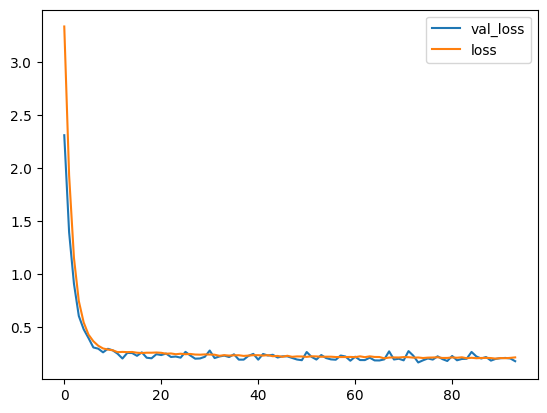

Real: [759124.039] | Predicción: [771673.94]
Real: [758265.98] | Predicción: [763279.6]
Real: [744050.02] | Predicción: [767297.6]
Real: [735427.048] | Predicción: [751489.4]
Real: [677992.558] | Predicción: [667492.44]
Real: [628491.111] | Predicción: [624789.8]
Real: [726597.17] | Predicción: [734454.94]
Real: [734120.281] | Predicción: [757708.2]
Real: [732237.567] | Predicción: [747995.94]
Real: [736907.737] | Predicción: [727476.75]
Real: [742820.885] | Predicción: [717996.8]
Real: [670693.047] | Predicción: [660390.1]
Real: [618013.898] | Predicción: [602389.06]
Real: [697748.424] | Predicción: [704716.9]
Real: [722629.686] | Predicción: [725171.1]
Real: [735689.298] | Predicción: [732355.44]
Real: [742779.369] | Predicción: [727305.5]
Real: [743386.909] | Predicción: [722121.4]
Real: [660787.324] | Predicción: [664963.6]
Real: [620251.472] | Predicción: [605951.8]
Real: [732493.133] | Predicción: [715223.56]
Real: [735113.962] | Predicción: [744211.9]
Real: [726757.341] | Predic

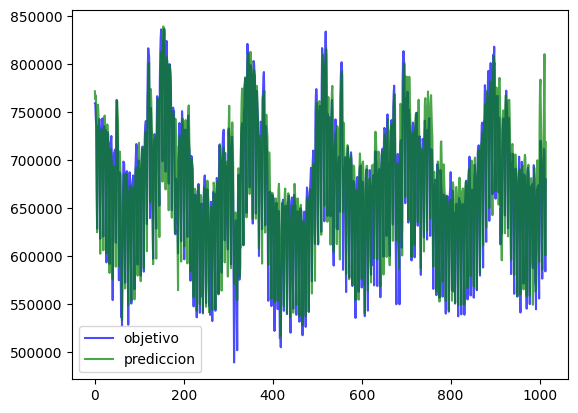

(<Sequential name=sequential_2, built=True>,
 <keras.src.callbacks.history.History at 0x1a9c6bea6d0>)

In [28]:
modelo_neuronal_GRU(X_train, y_train, X_test, y_test)

In [29]:
predictions_7_gru = predict_7_days(model_filename="gru_model.pkl")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [30]:
predictions_7_gru

array([[771673.94],
       [756508.  ],
       [751261.25],
       [746603.94],
       [674273.44],
       [652681.94],
       [717899.  ]], dtype=float32)

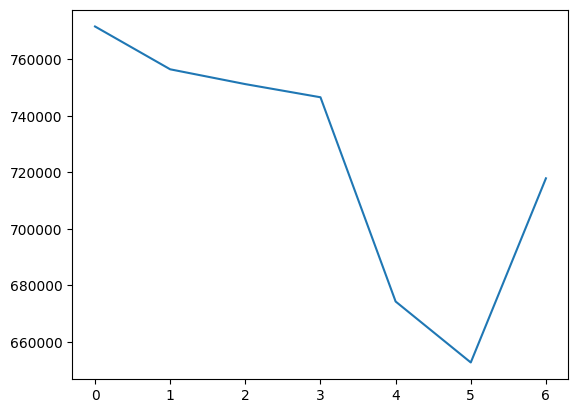

In [31]:
plt.plot(predictions_7_gru)

In [32]:
from prophet import Prophet

In [33]:
def model_prophet (df):

    # Preparación del df para procesar mediante Prophet 

    df = df.rename(columns={"año": "year", "mes": "month", "dia": "day"})
    df['fecha'] = pd.to_datetime(df[['year', 'month', 'day']])
    df_prophet=df[['valor_demanda_MW', 'fecha']]
    df_prophet=df.rename(columns={'valor_demanda_MW':'y', 'fecha':'ds'})
    df_prophet=df_prophet[['ds', 'y']]

    # Llamada y entrenamiento del modelo

    model=Prophet()
    model.fit(df_prophet)
    
    # Predicciones del modelo

    future=model.make_future_dataframe(periods=31)
    forecast=model.predict(future)

    # Preparación de las visualizaciones

    forecast_1=forecast[['ds','yhat_lower', 'yhat_upper', 'yhat']]
    fig_evol=model.plot(forecast_1)
    fig_granularity=model.plot_components(forecast)

    return plt.show(fig_evol), plt.show(fig_granularity)

00:59:13 - cmdstanpy - INFO - Chain [1] start processing
00:59:15 - cmdstanpy - INFO - Chain [1] done processing


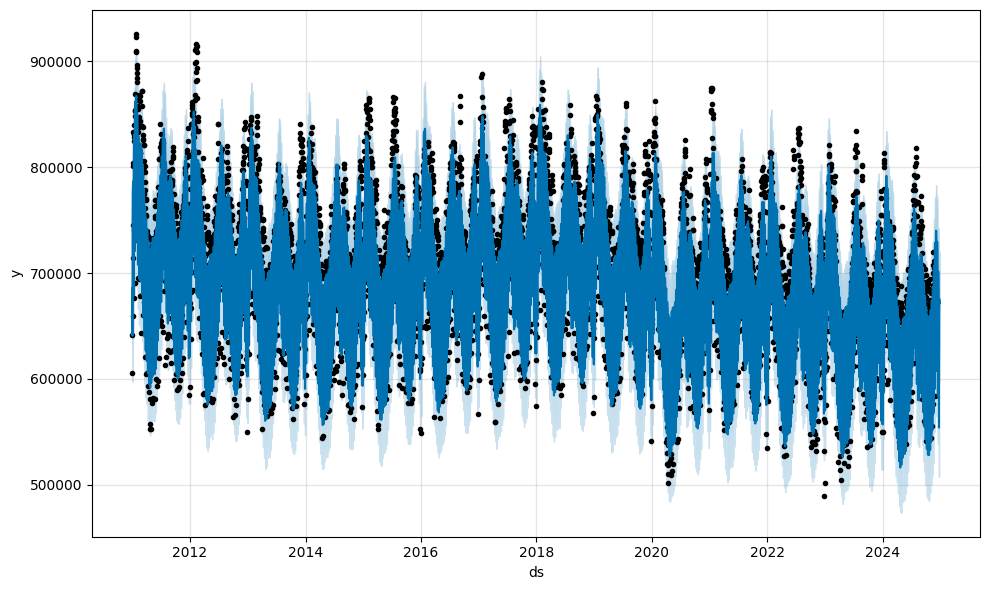

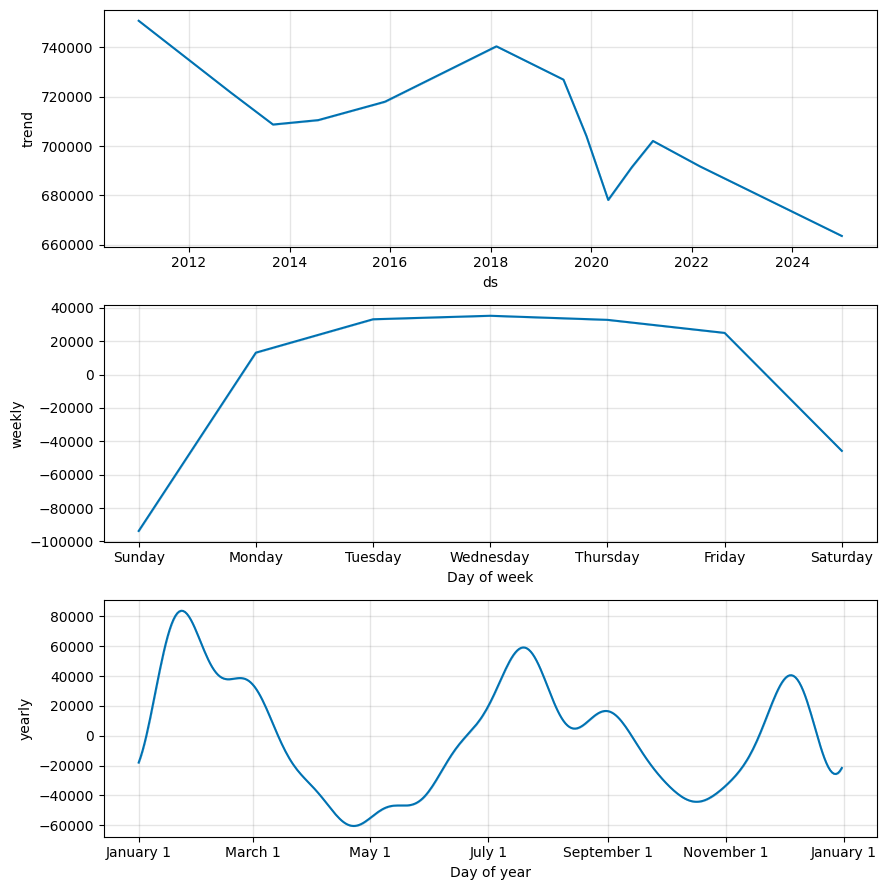

(None, None)

In [34]:
model_prophet(df)

In [35]:
import plotly.express as px

In [36]:
def visual_loss_rnn(history_filename='history_rnn.json'):
    
    with open(history_filename, "r") as f:
        history_rnn = json.load(f)

    df_rnn=pd.DataFrame(history_rnn)

    return px.line(df_rnn, y=['loss', 'val_loss'])

In [37]:
visual_loss_rnn()

In [38]:
def visual_loss_lstm(history_filename='history_lstm.json'):
    
    with open(history_filename, "r") as f:
        history_lstm = json.load(f)

    df_lstm=pd.DataFrame(history_lstm)

    return px.line(df_lstm, y=['loss', 'val_loss'])

In [39]:
visual_loss_lstm()

In [40]:
def visual_loss_gru(history_filename='history_gru.json'):
    
    with open(history_filename, "r") as f:
        history_gru = json.load(f)

    df_gru=pd.DataFrame(history_gru)

    return px.line(df_gru, y=['loss', 'val_loss'])

In [41]:
visual_loss_gru()